In [1]:
from sklearn.datasets import load_wine
data = load_wine()

In [2]:
import pandas as pd
import numpy as np

/home/andreas/projects/7scientists/kiprotect/workshops/data-privacy-for-data-scientists/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/andreas/projects/7scientists/kiprotect/workshops/data-privacy-for-data-scientists/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
Y = pd.DataFrame(data['target'],)
features= [[0, "f1"], [1, "f2"], [2, "f3"], [3, "f4"]]
X = pd.DataFrame(data['data'][:,[f[0] for f in features]], columns=[f[1] for f in features])
X=(X*100).astype(int)

In [4]:
actions = []
for i, f in features:
    actions.append(
        {
            "name": "pseudonymize-{}".format(f),
            "transform-value" : {
                "key": f,
                "pseudonymize" : {
                    "method": "structured",
                    "type" : "integer",
                    "prefixPreserving": True,
                    "typeParams" : {
                        "min" : int(X[f].min()),
                        "max" : int(X[f].max()),
                    },
                    "format" : "raw",
                    "key": "fresdse", 
                }
            }
        }
    )


In [5]:
import requests
import json

# This is a public API key which might be disabled in the future
# You can sign up for a real key here: https://app.kiprotect.com
SHARED_KEY = '42a2d3fc1cc449e2a27ddd457e056012'

data = requests.post(
    'https://api.kiprotect.com/v1/transform', 
    json = {"actions": actions, "items": X.astype('object').to_dict(orient='records')},
    headers = {'Authorization': 'Bearer {}'.format(
        SHARED_KEY)}
)

In [6]:
Xa = pd.DataFrame(data.json()['items'])

In [7]:
Xa = Xa.drop(columns=['_kip'])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
Xa_train, Xa_test, Ya_train, Ya_test = train_test_split(Xa, Y, test_size=0.5, random_state=42)

In [9]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [10]:
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
clfa = DecisionTreeClassifier()
clfa.fit(Xa_train, Ya_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [11]:
Y_pred_test = clf.predict(X_test)
Ya_pred_test = clfa.predict(Xa_test)

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(Y_pred_test,Y_test)

0.8089887640449438

In [14]:
accuracy_score(Ya_pred_test,Ya_test)

0.7415730337078652

In [15]:
%matplotlib inline
import matplotlib

font = {'size' : 16}
matplotlib.rc('font', **font)

import matplotlib.pylab as pl

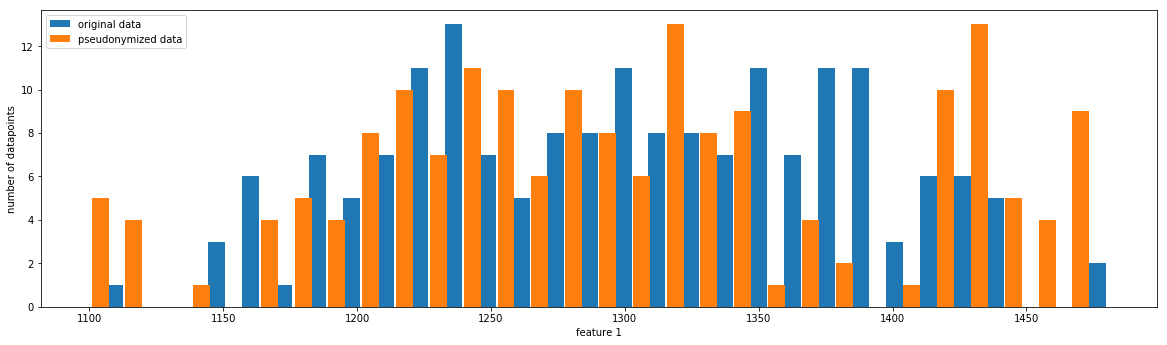

In [16]:
pl.figure(figsize=(20,12))
pl.subplot(211)
pl.hist(X['f1'], bins=30, rwidth=0.5, align='mid')
pl.hist(Xa['f1'], bins=30, rwidth=0.5, align='left');
pl.xlabel("feature 1")
pl.ylabel("number of datapoints")
pl.legend(["original data", "pseudonymized data"], loc='upper left')

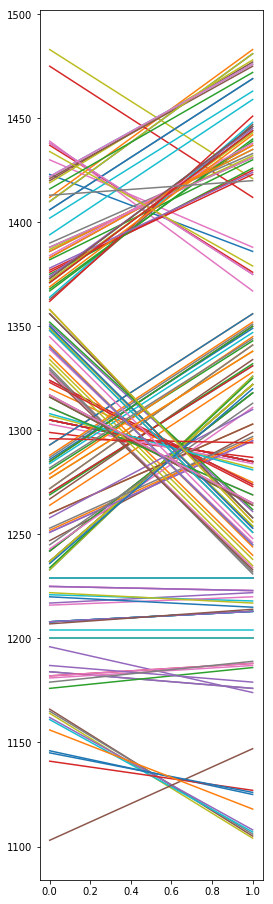

In [17]:
pl.figure(figsize=(4,16))
for i in range(len(X)):
    pl.plot([X.loc[i,"f1"], Xa.loc[i,"f1"]])